In [ ]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
import random

class Encoder(nn.Module):
  def __init__(self, embedding_dim, enc_hidden_dim, vocab_size):
    super().__init__()

    self.encoder = nn.LSTM(embedding_dim, enc_hidden_dim, batch_first=True, bidirectional=True)
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.enc_hidden_dim = enc_hidden_dim

  def forward(self, x:Tensor, lengths:Tensor):
    # x ->  (B, L) indices of words in sentences.
    # B-> Batch size
    # L-> Sequence Length
    # H-> Input size/embedding dimension
    # Hout-> encoder hidden dim
    # for example if there are 3 sentences each having 10 words, B=3, L=10, H=embedding dim
    emb = self.embedding(x) # (B, L, H)
    packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
    packed_out, hidden_n = self.encoder(packed)

    # unpack back to (B, L, 2*Hout), with true lengths
    h, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
    return h, hidden_n # h -> (B, L, D*Hout) where D=2 because it is bi-directional



In [ ]:
class Attention(nn.Module):
  def __init__(self, enc_hidden_dim, dec_hidden_dim, attn_dim):
    super().__init__()

    self.W_h = nn.Linear(enc_hidden_dim, attn_dim)
    self.W_s = nn.Linear(dec_hidden_dim, attn_dim)
    self.am = nn.Linear(attn_dim, 1) # alignment model
  def forward(self, h:Tensor, s:Tensor, mask:Tensor=None):
    # h-> (B, L, 2*enc_hidden_dim) encoder output

    # s-> (B, dec_hidden_dim) the decoder hidden state

    # project encoder output
    proj_enc = self.W_h(h) # (B, L, attn_dim)
    # project decoder hidden
    proj_dec = self.W_s(s).unsqueeze(1) # (B, 1, attn_dim)

    e = self.am(torch.tanh(proj_enc + proj_dec)).squeeze(-1) # (B, L)

    if mask is not None:
      # to ensure that padded positions after softmax have their weights to be zero
      # which means; do not pay attention here.
      e = e.masked_fill(mask==0, value=float("-inf"))

    attn_weights = torch.softmax(e, dim=-1) # (B, L)

    context = torch.bmm(attn_weights.unsqueeze(1), h).squeeze(1) # (B, 2*enc_hidden_dim)

    return context, attn_weights


In [ ]:
class GenerateWordProb(nn.Module):
  def __init__(self, dec_hidden_dim, enc_hidden_dim, vocab_size):
    super().__init__()

    self.fc1 = nn.Linear(dec_hidden_dim + enc_hidden_dim, vocab_size)
    self.dropout = nn.Dropout(0.4)
  def forward(self, context, decoder_output):
    enc_dec_output = torch.cat([context, decoder_output], dim=-1) # (B, dec_hidden_dim + enc_hidden_dim)
    enc_dec_output = self.dropout(enc_dec_output)
    logits = self.fc1(enc_dec_output) # (B, vocab_size)
    return logits

In [ ]:
class Decoder(nn.Module):
  def __init__(self, dec_hidden_dim, vocab_size, embedding_dim, enc_hidden_dim, attn_dim):
    super().__init__()

    enc_hidden_dim = 2*enc_hidden_dim # because of bidirectional encoder
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    # input to decoder is the is the previous generated token, the context vector and the hidden state.
    # 2*enc_hidden_dim:  is because the context is coming from a bidirectional encoder
    self.decoder = nn.LSTM(embedding_dim + enc_hidden_dim, dec_hidden_dim, batch_first=True)
    self.attn = Attention(enc_hidden_dim, dec_hidden_dim, attn_dim)

    self.out = GenerateWordProb(dec_hidden_dim, enc_hidden_dim, vocab_size)

    self.dec_hidden_dim = dec_hidden_dim
    # projection layers for h and c
    self.h_proj = nn.Linear(enc_hidden_dim, dec_hidden_dim)
    self.c_proj = nn.Linear(enc_hidden_dim, dec_hidden_dim)

  def init_hidden(self, hidden_n):
    # initialize hidden state

    h, c = hidden_n  # (num_layers*2, B, Hout)
    # concat forward/backward hidden states from last layer
    h_cat = torch.cat((h[-2], h[-1]), dim=-1)  # (B, 2*Hout)
    c_cat = torch.cat((c[-2], c[-1]), dim=-1)  # (B, 2*Hout)

    # project to decoder hidden size
    h0 = torch.tanh(self.h_proj(h_cat)).unsqueeze(0)  # (1, B, dec_hidden_dim)
    c0 = torch.tanh(self.c_proj(c_cat)).unsqueeze(0)  # (1, B, dec_hidden_dim)

    # init hidden state for decoder
    hidden = (h0, c0)
    return hidden

  def forward_step(self, x:Tensor, encoder_output:Tensor, last_hidden:Tuple[Tensor, Tensor], mask=None):
    """Because the decoder depends on the previously generated token as an input
      The attention context is recomputed at every step based on the current decoder hidden state.
      The hidden state evolves step-by-step, so you can't precompute all decoder states in parallel.
      Therefore we will use a for loop to iterate over each step.
    """
    # x -> (B,) indices of words
    # encoder_output (h) -> (B, L, 2*enc_hidden_dim)

    emb = self.embedding(x) # (B, embedding_dim)

    s_n = last_hidden[0].squeeze(0) # (1, B, dec_hidden_dim) the decoder hidden state

    contexts, attn_weights = self.attn(encoder_output, s_n, mask)
    # contexts -> (B, 2*enc_hidden_dim)

    decoder_in = torch.cat([emb.unsqueeze(1), contexts.unsqueeze(1)], dim=-1) # (B, 1, embedding_dim + 2*enc_hidden_dim)

    output, new_hidden = self.decoder(decoder_in, last_hidden) # output -> (B, 1, dec_hidden_dim)

    logits = self.out(contexts, output.squeeze(1)) # (B, vocab_size)

    return logits, new_hidden, attn_weights

  def forward(self, target_seq:Tensor, encoder_output:Tensor, hidden_n:Tuple[Tensor, Tensor], mask=None, teacher_forcing_ratio=0.5, use_enc_hidden=False):
    """
    target_seq (B, target_seq_len) indices of target words

    In sequence-to-sequence models (like RNNs with attention), teacher forcing is a training strategy where the
    model is fed the ground truth token from the previous time step instead of its own prediction.
    The teacher forcing ratio is a probability (between 0 and 1) that determines how often this happens.
    If a random number < teacher_forcing_ratio, then ground truth token is used as input for the next step.
    Otherwise, the model uses its own predicted token from the previous step.

    hidden_n; the encoder last hidden and cell state
    """
    B, seq_len = target_seq.size()

    logits_seq = []
    attn_seq = []
    x = target_seq[:, 0] # (B,) the first token is <sos>

    if use_enc_hidden:
      hidden = self.init_hidden(hidden_n)
    else:
      s_n_init = torch.zeros(1, B, self.dec_hidden_dim).to(target_seq.device)
      c_n_init = torch.zeros(1, B, self.dec_hidden_dim).to(target_seq.device)

      init_hidden = (s_n_init, c_n_init)
      hidden = init_hidden

    for t in range(1, seq_len): # starting from one because we want to skip the <sos> token
      logits, hidden, attn_weights = self.forward_step(x, encoder_output, hidden, mask)
      logits_seq.append(logits.unsqueeze(1))
      attn_seq.append(attn_weights.unsqueeze(1))
      teacher_force = random.random() < teacher_forcing_ratio
      if teacher_force:
        # Ground truth
        x = target_seq[:, t]
      else:
        x = logits.argmax(dim=-1)
    logits_seq = torch.cat(logits_seq, dim=1) # (B, target_seq_len-1, vocab)
    attn_seq = torch.cat(attn_seq, dim=1) #  (B, target_seq_len-1, L)
    return logits_seq, attn_seq






In [ ]:
def make_mask(data:Tensor, pad_idx=0):
  # data -> (B, seq_len)
  return (data != pad_idx).to(data.device)

In [ ]:
# Creating a synthetic dataset to test my implementation of attention
from torch.utils.data import Dataset, DataLoader
import random
class SyntheticDataset(Dataset):
  def __init__(self, n_samples=10000, seq_len=10, vocab_size=50, task="copy"):
    super().__init__()
    self.samples = []
    for _ in range(n_samples):
      length = random.randint(3, seq_len)
      seq = [random.randint(3, vocab_size-1) for _ in range(length)]

      if task == 'copy':
        target = seq[:]
      elif task == 'reverse':
        target = seq[::-1]

      # add <sos>=1 and <eos>=2 for target
      self.samples.append((seq, [1]+target+[2]))

    self.vocab_size = vocab_size
  def __len__(self):
    return len(self.samples)
  def __getitem__(self, idx):
    return self.samples[idx]



In [ ]:
# set up collate function for dataloader
def collate_fn(batch, pad_idx=0):
  data, target = zip(*batch)
  data_lengths = [len(seq) for seq in data]
  max_data_len = max(data_lengths)
  max_tgt_len = max([len(tgt) for tgt in target])
  padded_data = [seq + [pad_idx]*(max_data_len-len(seq)) for seq in data]
  padded_target = [seq + [pad_idx]*(max_tgt_len-len(seq)) for seq in target]
  return torch.tensor(padded_data), torch.tensor(padded_target), torch.tensor(data_lengths)

In [ ]:
dataset = SyntheticDataset(n_samples=10000, seq_len=12, vocab_size=50, task='reverse')
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [ ]:
# Initialise model
encoder = Encoder(embedding_dim=64, enc_hidden_dim=128, vocab_size=dataset.vocab_size)
decoder = Decoder(dec_hidden_dim=128, vocab_size=dataset.vocab_size, embedding_dim=64, enc_hidden_dim=128, attn_dim=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

Decoder(
  (embedding): Embedding(50, 64, padding_idx=0)
  (decoder): LSTM(320, 128, batch_first=True)
  (attn): Attention(
    (W_h): Linear(in_features=256, out_features=64, bias=True)
    (W_s): Linear(in_features=128, out_features=64, bias=True)
    (am): Linear(in_features=64, out_features=1, bias=True)
  )
  (out): GenerateWordProb(
    (fc1): Linear(in_features=384, out_features=50, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (h_proj): Linear(in_features=256, out_features=128, bias=True)
  (c_proj): Linear(in_features=256, out_features=128, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [ ]:
epochs =  10
encoder.train()
decoder.train()
for epoch in range(epochs):
  running_loss = 0.0
  for data, target, lengths in train_loader:
    data = data.to(device)
    target = target.to(device)
    lengths = lengths.to(device)

    optimizer.zero_grad()
    encoder_output, hidden_n = encoder(data, lengths)
    mask = make_mask(data)
    logits_seq, attn_seq = decoder(target, encoder_output, hidden_n, mask=mask, teacher_forcing_ratio=0.5)
    # logits seq is (B, target_seq_len-1, vocab)
    tgts = target[:, 1:logits_seq.size(1)+1]
    loss = criterion(logits_seq.view(-1, logits_seq.size(-1)), tgts.reshape(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, 1.0)
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 2.3242060840129852
Epoch 2, Loss: 0.4465853155228742
Epoch 3, Loss: 0.26459415764755506
Epoch 4, Loss: 0.14399968214617792
Epoch 5, Loss: 0.08282175400905359
Epoch 6, Loss: 0.07343465957351646
Epoch 7, Loss: 0.08730173831105612
Epoch 8, Loss: 0.04399116863170342
Epoch 9, Loss: 0.06232075718569623
Epoch 10, Loss: 0.05614654439098089


In [ ]:
def test_model(seq, max_len=20):
  encoder.eval(); decoder.eval()
  src = torch.tensor([seq], device=device)
  length = torch.tensor([len(seq)], device=device)
  with torch.no_grad():
      enc_out, hidden_n = encoder(src, length)
      mask = make_mask(src)

      # initialize hidden state
      #hidden = decoder.init_hidden(hidden_n)
      B = src.size(0)
      s_n_init = torch.zeros(1, B, decoder.dec_hidden_dim).to(device)
      c_n_init = torch.zeros(1, B, decoder.dec_hidden_dim).to(device)

      init_hidden = (s_n_init, c_n_init)
      hidden = init_hidden

      # start with <sos>
      x = torch.tensor([1], device=device)  # (B,)
      preds, attns = [], []

      for _ in range(max_len):
        logits, hidden, attn_weights = decoder.forward_step(x, enc_out, hidden, mask)
        next_token = logits.argmax(-1)  # greedy
        preds.append(next_token.item())
        attns.append(attn_weights.unsqueeze(1))

        if next_token.item() == 2:  # <eos>
          break
        x = next_token  # feed back prediction

  attns = torch.cat(attns, dim=1)
  return preds, attns


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_attention(attention_weights, src_seq, tgt_seq, idx2token=None, title="Attention Heatmap"):
    """
    Plots a heatmap of attention weights between source and target sequences.

    Args:
        attention_weights (torch.Tensor): [tgt_len, src_len] tensor (after softmax).
        src_seq (list[int]): Source token IDs (e.g. input sequence).
        tgt_seq (list[int]): Target token IDs (e.g. predicted output sequence).
        idx2token (dict[int,str], optional): Mapping from token ID to string for readability.
        title (str): Title of the plot.
    """

    # Convert token IDs to strings if mapping provided
    if idx2token is not None:
        src_labels = [idx2token[idx] for idx in src_seq]
        tgt_labels = [idx2token[idx] for idx in tgt_seq]
    else:
        src_labels = [str(idx) for idx in src_seq]
        tgt_labels = [str(idx) for idx in tgt_seq]

    # Prepare attention matrix
    attn = attention_weights.detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(attn,
                     xticklabels=src_labels,
                     yticklabels=tgt_labels,
                     cmap="viridis",
                     cbar=True,
                     linewidths=0.5,
                     linecolor="gray",
                     annot=True,  # write values in cells
                     fmt=".2f")

    plt.xlabel("Source Sequence (Input)")
    plt.ylabel("Target Sequence (Output)")
    plt.title(title, fontsize=14, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


In [ ]:
# Try with a random input
test_seq = [7, 9, 25, 26, 23, 23]
print("Input:", test_seq)
pred, attn_weights = test_model(test_seq)
print("Predicted Output:", pred)
print("Expected Output:", test_seq[::-1] + [2])  # reversed + <eos>

Input: [7, 9, 25, 26, 23, 23]
Predicted Output: [23, 23, 26, 25, 9, 7, 2]
Expected Output: [23, 23, 26, 25, 9, 7, 2]


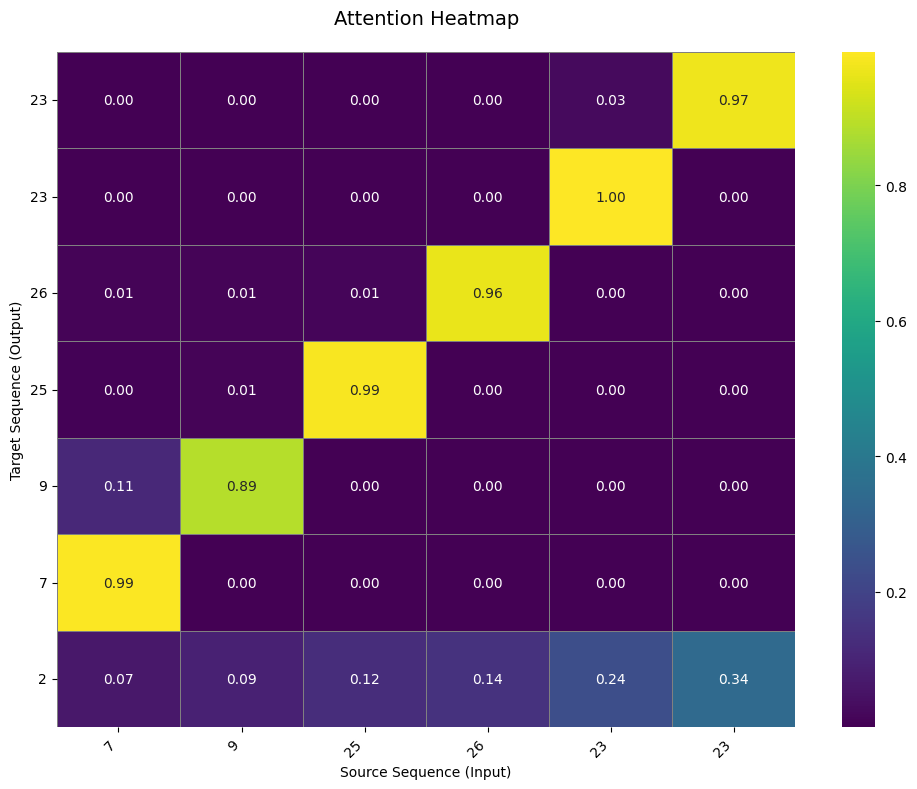

In [ ]:
plot_attention(attn_weights[0], test_seq, pred)